<a href="https://colab.research.google.com/github/pythonuzgit/Computer-Vision/blob/master/Computer%20Vision/African_plums_classification_analysis_with_ModeleNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip '/content/african-plums-quality-and-defect-assessment-data.zip'

Archive:  /content/african-plums-quality-and-defect-assessment-data.zip
  inflating: african_plums_dataset/README.md  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_1.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_10.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_100.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_101.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_102.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_103.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_104.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_105.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_106.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_107.png  
  inflating: african_plums_dataset/african_plums/bruised/bruised_plum_108.png  
  in

In [ ]:
# import-necessary-libraries

import numpy as np
import pandas as pd
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import os
import cv2
import random

from PIL import Image # for image

import tensorflow as tf
import keras
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow import keras
from tensorflow.keras import layers, regularizers, models, optimizers
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import array_to_img

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load-the-dataset
# Define image data path
image_data_dir = '/content/african_plums_dataset/african_plums'

# Gather all file paths using glob
train_files = glob.glob(os.path.join(image_data_dir, '*', '*'))

# Shuffle the file list using random.shuffle for better performance
random.shuffle(train_files)

# Extract labels from the file paths (assuming label is the folder name)
train_labels = [os.path.basename(os.path.dirname(file)) for file in train_files]

# Create the DataFrame with the image paths and corresponding labels
train_df = pd.DataFrame({
    'image': train_files,
    'label': train_labels
})

train_df


image       label
0     /content/african_plums_dataset/african_plums/u...  unaffected
1     /content/african_plums_dataset/african_plums/s...     spotted
2     /content/african_plums_dataset/african_plums/u...      unripe
3     /content/african_plums_dataset/african_plums/b...     bruised
4     /content/african_plums_dataset/african_plums/u...  unaffected
...                                                 ...         ...
4502  /content/african_plums_dataset/african_plums/u...  unaffected
4503  /content/african_plums_dataset/african_plums/s...     spotted
4504  /content/african_plums_dataset/african_plums/s...     spotted
4505  /content/african_plums_dataset/african_plums/u...  unaffected
4506  /content/african_plums_dataset/african_plums/c...     cracked

[4507 rows x 2 columns]

In [ ]:
train_labels[:10]

['unaffected',
 'spotted',
 'unripe',
 'bruised',
 'unaffected',
 'bruised',
 'unaffected',
 'unaffected',
 'unripe',
 'unaffected']

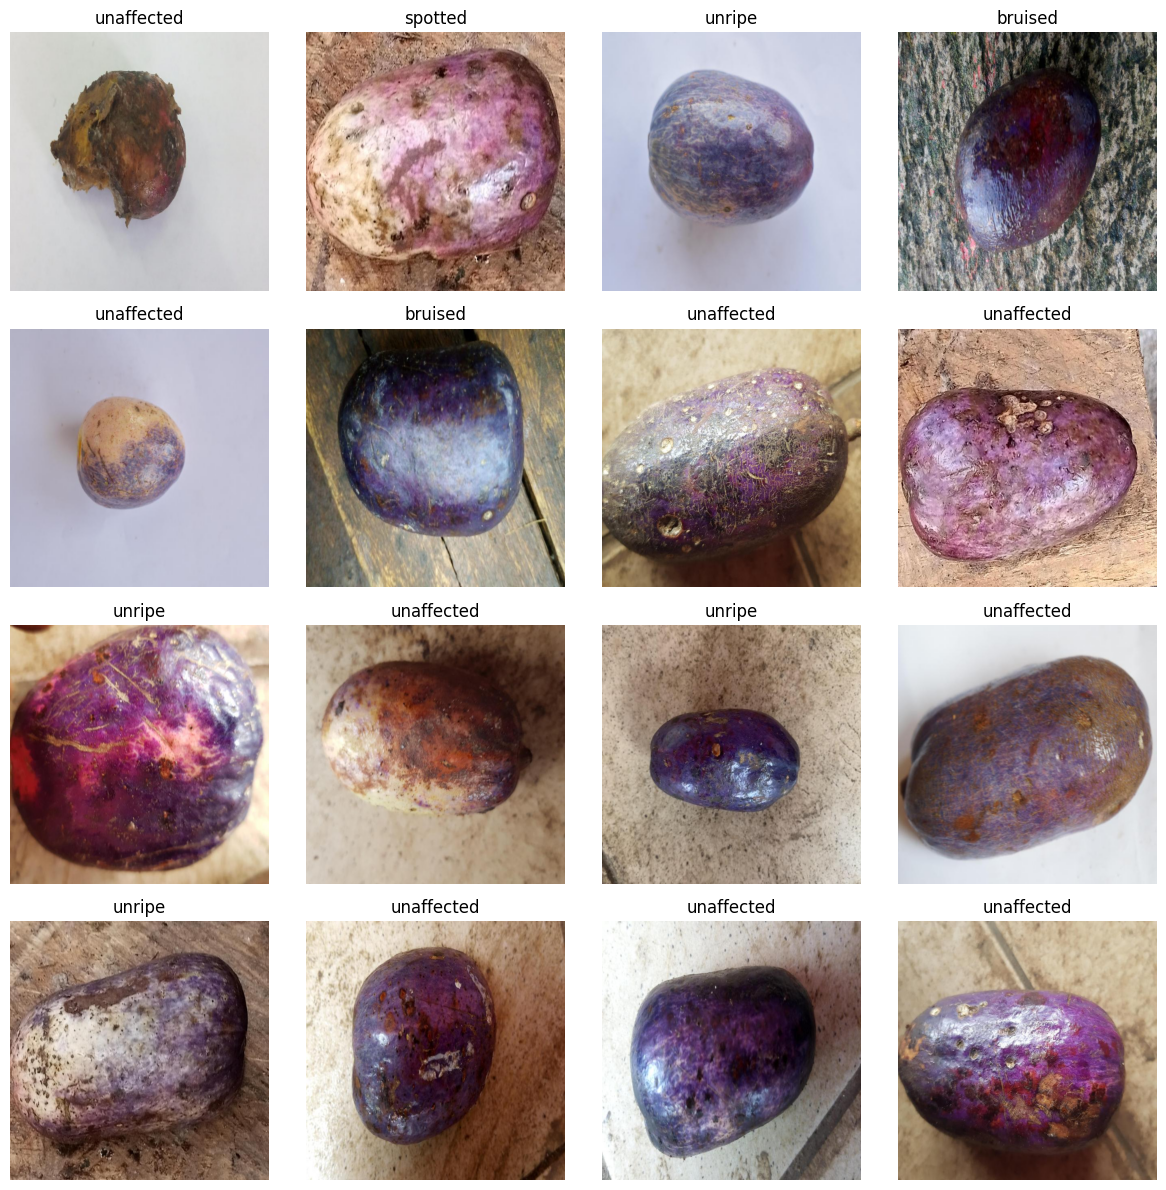

In [ ]:
num_images = 16 # number of images to display
sample_images = train_df.sample(num_images)['image'].values # random sample of images


fig, axes = plt.subplots(4, 4, figsize=(12, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.2) # spacing between images

for i, ax in enumerate(axes.flat):
    # Open the image file
    img = Image.open(sample_images[i])
    ax.imshow(img) # display images
    ax.set_title(train_labels[i]) # set title
    ax.axis('off') # Remove axis labels for a cleaner look
plt.tight_layout()
plt.show()

In [ ]:
# unique train labels

np.unique(train_labels)

array(['bruised', 'cracked', 'rotten', 'spotted', 'unaffected', 'unripe'],
      dtype='<U10')

In [ ]:
# Variable setup
batch_size = 8
target_size = (224, 224)
validation_split = 0.2
test_split = 0.1

# Load all data
all_data = tf.keras.preprocessing.image_dataset_from_directory(
            image_data_dir,
            image_size=target_size,
            batch_size=batch_size,
            shuffle=True,  # Shuffle to ensure randomness in splits
        )

# Calculate the sizes for splitting the dataset
dataset_size = tf.data.experimental.cardinality(all_data).numpy()
train_size = int(dataset_size * (1 - validation_split - test_split))
validation_size = int(dataset_size * validation_split)

# Split the dataset into train, validation, and test sets
train_dataset = all_data.take(train_size)
remaining_data = all_data.skip(train_size)
validation_dataset = remaining_data.take(validation_size)
test_dataset = remaining_data.skip(validation_size)

Found 4507 files belonging to 6 classes.


Splitting the data

In [ ]:
# data-splitting
# Get the size of the complete dataset
dataset_size = tf.data.experimental.cardinality(all_data).numpy()

# Get the sizes of the datasets
train_size = tf.data.experimental.cardinality(train_dataset).numpy()
validation_size = tf.data.experimental.cardinality(validation_dataset).numpy()
test_size = tf.data.experimental.cardinality(test_dataset).numpy()

# Calculate the proportions
train_proportion = train_size / dataset_size
validation_proportion = validation_size / dataset_size
test_proportion = test_size / dataset_size

# proportion
print(f"Train dataset proportion: {train_proportion:.2%}")
print(f"Validation dataset proportion: {validation_proportion:.2%}")
print(f"Test dataset proportion: {test_proportion:.2%}")

Train dataset proportion: 69.86%
Validation dataset proportion: 19.86%
Test dataset proportion: 10.28%


Model implementation

In [ ]:
img_height, img_width = 224, 224
batch_size = 32
epochs = 10

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow import keras
from tensorflow.keras.applications import MobileNetV2

img_height, img_width = 224, 224
batch_size = 32
#epochs = 10

base_model = MobileNetV2(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')
base_model.trainable = False

# Build the Sequential model
# Wrap the base_model in a Keras Input layer to define the input shape
input_tensor = keras.Input(shape=(img_height, img_width, 3))
x = base_model(input_tensor)  # Pass the input tensor to the base_model
x = keras.layers.GlobalAveragePooling2D()(x)  # Apply GlobalAveragePooling2D to the output of base_model
x = keras.layers.Dense(128, activation='relu')(x)  # Dense layer with 128 units and ReLU activation
x = keras.layers.Dropout(0.5)(x)  # Dropout layer for regularization
output_tensor = keras.layers.Dense(6, activation='softmax')(x)  # Final classification layer with 4 output classes

# Create the model using the input and output tensors
model1 = keras.Model(inputs=input_tensor, outputs=output_tensor)

# Display the model summary
model1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Define callbacks more explicitly for better control
callbacks = [
    ModelCheckpoint("base_model.keras", save_best_only=True, monitor='val_loss', mode='min'),
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')
    ]

# Compile the model with specified learning rate for Adam optimizer
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Set learning rate for Adam optimizer
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

# Fit the model with the specified callbacks
hist1 = model1.fit(
    train_dataset,
    epochs = 50,
    validation_data = validation_dataset,
    callbacks = callbacks
)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 188s 443ms/step - accuracy: 0.3204 - loss: 1.7111 - val_accuracy: 0.4777 - val_loss: 1.4334
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 170s 432ms/step - accuracy: 0.4575 - loss: 1.4491 - val_accuracy: 0.5000 - val_loss: 1.3699
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 171s 434ms/step - accuracy: 0.4903 - loss: 1.3879 - val_accuracy: 0.5167 - val_loss: 1.3280
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 171s 434ms/step - accuracy: 0.4774 - loss: 1.3719 - val_accuracy: 0.5190 - val_loss: 1.3044
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 173s 438ms/step - accuracy: 0.5183 - loss: 1.3090 - val_accuracy: 0.5179 - val_loss: 1.2918
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 171s 433ms/step - accuracy: 0.5186 - loss: 1.2927 - val_accuracy: 0.5190 - val_loss: 1.2778
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 170s 431ms/step - accuracy: 0.5217 - loss: 1.2594 - val_accuracy: 0.5301 - val_loss: 1.2513
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 171s 433ms/step - accuracy: 0.5461 -

Visualize metrics

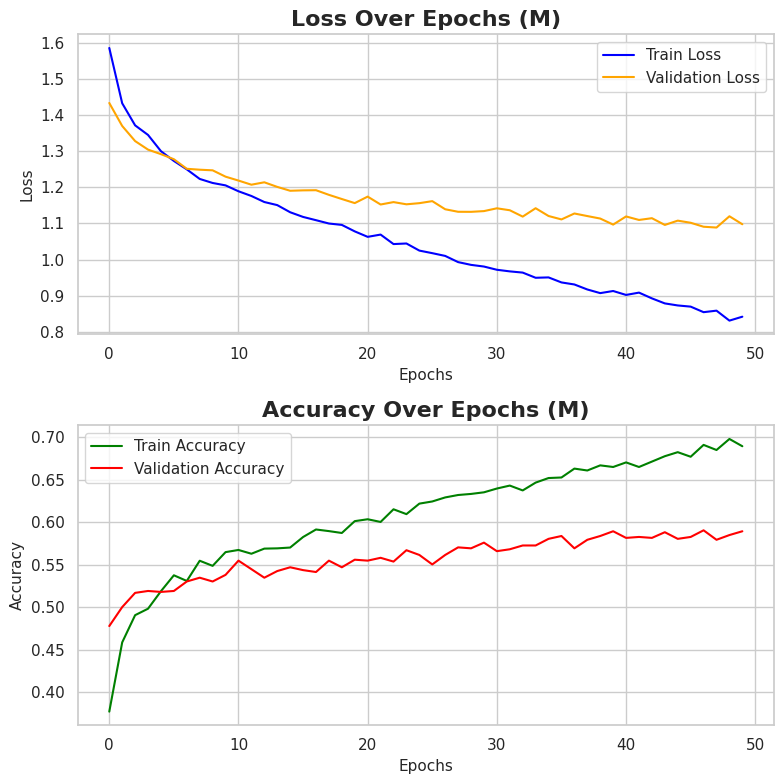

In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

def plot_model(histories, model_names=("Model 1")):
    sns.set(style="whitegrid")

    # Define metrics to plot and their corresponding titles and labels
    metrics = [('loss', 'Loss'), ('accuracy', 'Accuracy')]

    # fig, axs = plt.subplots(2, figsize=(12, 12)) #Original code, creates a 1D array for axs
    fig, axs = plt.subplots(2, 1, figsize=(8, 8)) #Creates a 2D array of subplots with 2 rows and 1 column.

    for i, (history, model_name) in enumerate(zip(histories, model_names)):
        for j, (metric, label) in enumerate(metrics):
            # Plot for train and validation metrics
            axs[j].plot(history.history[metric], label=f'Train {label}', color='blue' if label == 'Loss' else 'green') #Access the subplots using a single index, j, corresponding to the row of the subplot.
            axs[j].plot(history.history[f'val_{metric}'], label=f'Validation {label}', color='orange' if label == 'Loss' else 'red')
            axs[j].set_title(f'{label} Over Epochs ({model_name})', fontsize=16, weight='bold')
            axs[j].set_xlabel('Epochs', fontsize=11)
            axs[j].set_ylabel(label, fontsize=11)
            axs[j].legend()
            axs[j].grid(True)

    plt.tight_layout()
    plt.show()


plot_model([hist1], model_names=("ModelNet"))

Test Performance

In [ ]:
predictions = model1.evaluate(test_dataset)

58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 323ms/step - accuracy: 0.4993 - loss: 1.3658


Predict and display

using Model 1:
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


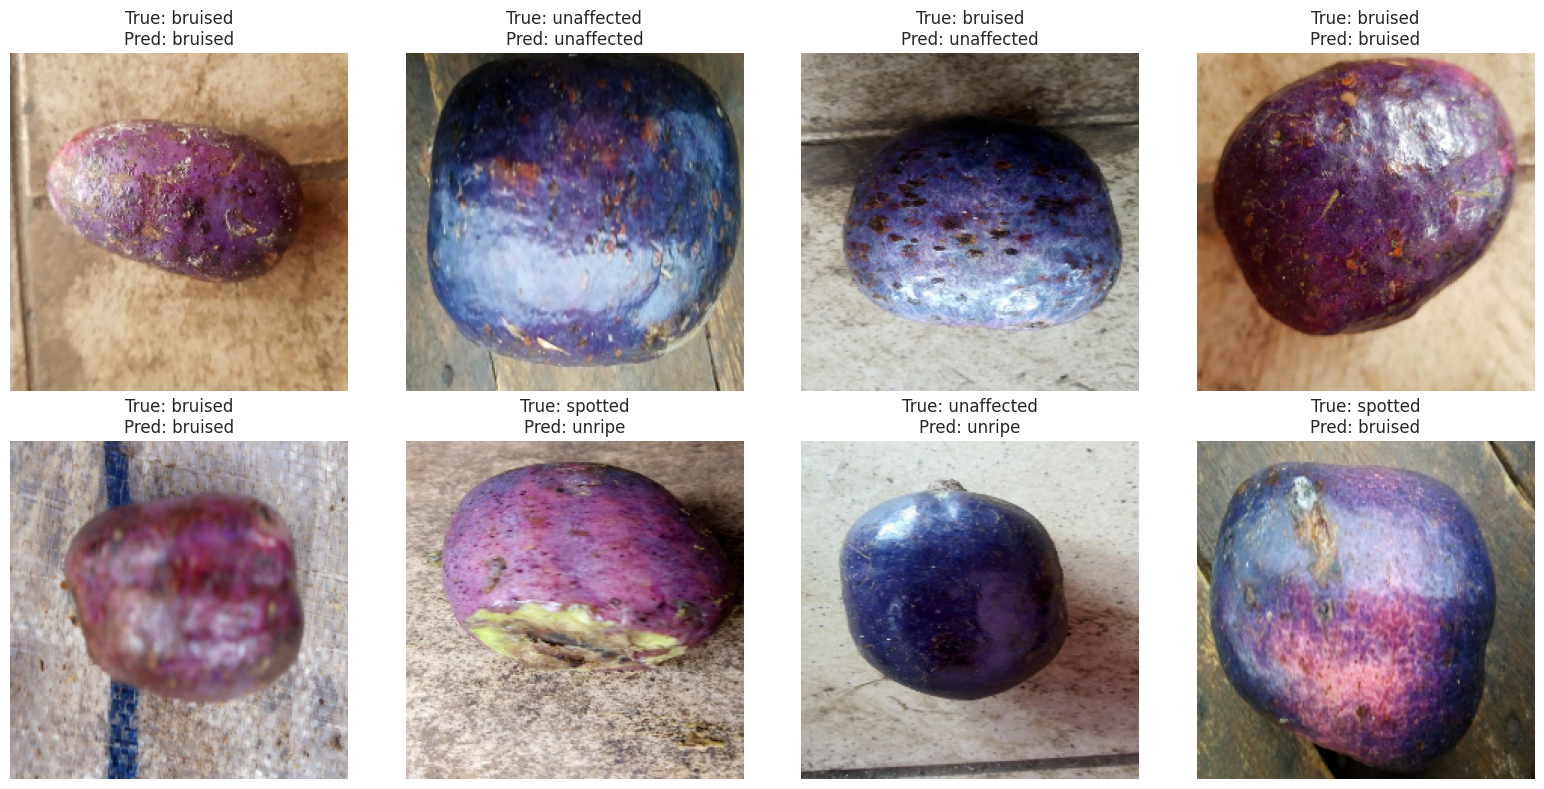

In [ ]:

def predict_and_display_images(model, dataset, class_names, num_images=8):
    # Select a batch of images from the test dataset
    image_batch, label_batch = next(iter(dataset.take(1)))  # Get a single batch of images
    image_batch = image_batch[:num_images]
    label_batch = label_batch[:num_images]

    # Make predictions on the batch
    predictions = model.predict(image_batch)
    predicted_classes = np.argmax(predictions, axis=1)

    # Plot the images with predicted and true labels
    plt.figure(figsize=(16, 8))
    for i in range(num_images):
        ax = plt.subplot(2, 4, i + 1)
        img = array_to_img(image_batch[i])  # Convert back to a displayable image format
        plt.imshow(img)
        true_label = class_names[label_batch[i]]
        predicted_label = class_names[predicted_classes[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage:
print("using Model 1:")
predict_and_display_images(model1, test_dataset, class_names=train_labels, num_images=8)